# Imports

In [1]:
import os
import sys
import time

PARENT_DIR = os.path.dirname(os.path.realpath(os.getcwd()))
sys.path.append(PARENT_DIR)

from tqdm import tqdm
from pathlib import Path
import pickle
import json 
import gc

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from ak_data_loader import load_data, get_balanced_data, normalize_features

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [15]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, mean_absolute_error
from scipy.stats import entropy
from itertools import combinations
from sklearn.metrics import mutual_info_score, confusion_matrix

## Feature Lists

#### 00

In [3]:
META_FEATURES = ['gene_length', 'gene_type', 'gene_chr']

ENHANCER_DMR_FEATURES = ['9mo.2mo.activity.log_ratio.mean.0-10kb','9mo.2mo.activity.log_ratio.median.0-10kb','9mo.2mo.activity.log_ratio.std.0-10kb','9mo.2mo.activity.log_ratio.skew.0-10kb',
                          '9mo.2mo.activity.log_ratio.max.0-10kb','9mo.2mo.activity.log_ratio.min.0-10kb','9mo.2mo.activity.log_ratio.count.0-10kb','18mo.2mo.activity.log_ratio.mean.0-10kb',
                          '18mo.2mo.activity.log_ratio.median.0-10kb','18mo.2mo.activity.log_ratio.std.0-10kb','18mo.2mo.activity.log_ratio.skew.0-10kb','18mo.2mo.activity.log_ratio.max.0-10kb',
                          '18mo.2mo.activity.log_ratio.min.0-10kb','18mo.2mo.activity.log_ratio.count.0-10kb','18mo.9mo.activity.log_ratio.mean.0-10kb','18mo.9mo.activity.log_ratio.median.0-10kb',
                          '18mo.9mo.activity.log_ratio.std.0-10kb','18mo.9mo.activity.log_ratio.skew.0-10kb','18mo.9mo.activity.log_ratio.max.0-10kb','18mo.9mo.activity.log_ratio.min.0-10kb',
                          '18mo.9mo.activity.log_ratio.count.0-10kb','9mo.2mo.contact.log_ratio.mean.0-10kb','9mo.2mo.contact.log_ratio.median.0-10kb','9mo.2mo.contact.log_ratio.std.0-10kb',
                          '9mo.2mo.contact.log_ratio.skew.0-10kb','9mo.2mo.contact.log_ratio.max.0-10kb','9mo.2mo.contact.log_ratio.min.0-10kb','9mo.2mo.contact.log_ratio.count.0-10kb',
                          '18mo.2mo.contact.log_ratio.mean.0-10kb','18mo.2mo.contact.log_ratio.median.0-10kb','18mo.2mo.contact.log_ratio.std.0-10kb','18mo.2mo.contact.log_ratio.skew.0-10kb',
                          '18mo.2mo.contact.log_ratio.max.0-10kb','18mo.2mo.contact.log_ratio.min.0-10kb','18mo.2mo.contact.log_ratio.count.0-10kb','18mo.9mo.contact.log_ratio.mean.0-10kb',
                          '18mo.9mo.contact.log_ratio.median.0-10kb','18mo.9mo.contact.log_ratio.std.0-10kb','18mo.9mo.contact.log_ratio.skew.0-10kb','18mo.9mo.contact.log_ratio.max.0-10kb',
                          '18mo.9mo.contact.log_ratio.min.0-10kb','18mo.9mo.contact.log_ratio.count.0-10kb','9mo.2mo.activity.log_ratio.mean.10kb-20kb','9mo.2mo.activity.log_ratio.median.10kb-20kb',
                          '9mo.2mo.activity.log_ratio.std.10kb-20kb','9mo.2mo.activity.log_ratio.skew.10kb-20kb','9mo.2mo.activity.log_ratio.max.10kb-20kb','9mo.2mo.activity.log_ratio.min.10kb-20kb',
                          '9mo.2mo.activity.log_ratio.count.10kb-20kb','18mo.2mo.activity.log_ratio.mean.10kb-20kb','18mo.2mo.activity.log_ratio.median.10kb-20kb','18mo.2mo.activity.log_ratio.std.10kb-20kb',
                          '18mo.2mo.activity.log_ratio.skew.10kb-20kb','18mo.2mo.activity.log_ratio.max.10kb-20kb','18mo.2mo.activity.log_ratio.min.10kb-20kb','18mo.2mo.activity.log_ratio.count.10kb-20kb',
                          '18mo.9mo.activity.log_ratio.mean.10kb-20kb','18mo.9mo.activity.log_ratio.median.10kb-20kb','18mo.9mo.activity.log_ratio.std.10kb-20kb','18mo.9mo.activity.log_ratio.skew.10kb-20kb',
                          '18mo.9mo.activity.log_ratio.max.10kb-20kb','18mo.9mo.activity.log_ratio.min.10kb-20kb','18mo.9mo.activity.log_ratio.count.10kb-20kb','9mo.2mo.contact.log_ratio.mean.10kb-20kb',
                          '9mo.2mo.contact.log_ratio.median.10kb-20kb','9mo.2mo.contact.log_ratio.std.10kb-20kb','9mo.2mo.contact.log_ratio.skew.10kb-20kb','9mo.2mo.contact.log_ratio.max.10kb-20kb',
                          '9mo.2mo.contact.log_ratio.min.10kb-20kb','9mo.2mo.contact.log_ratio.count.10kb-20kb','18mo.2mo.contact.log_ratio.mean.10kb-20kb','18mo.2mo.contact.log_ratio.median.10kb-20kb',
                          '18mo.2mo.contact.log_ratio.std.10kb-20kb','18mo.2mo.contact.log_ratio.skew.10kb-20kb','18mo.2mo.contact.log_ratio.max.10kb-20kb','18mo.2mo.contact.log_ratio.min.10kb-20kb',
                          '18mo.2mo.contact.log_ratio.count.10kb-20kb','18mo.9mo.contact.log_ratio.mean.10kb-20kb','18mo.9mo.contact.log_ratio.median.10kb-20kb','18mo.9mo.contact.log_ratio.std.10kb-20kb',
                          '18mo.9mo.contact.log_ratio.skew.10kb-20kb','18mo.9mo.contact.log_ratio.max.10kb-20kb','18mo.9mo.contact.log_ratio.min.10kb-20kb','18mo.9mo.contact.log_ratio.count.10kb-20kb',
                          '9mo.2mo.activity.log_ratio.mean.20kb-1Mb','9mo.2mo.activity.log_ratio.median.20kb-1Mb','9mo.2mo.activity.log_ratio.std.20kb-1Mb','9mo.2mo.activity.log_ratio.skew.20kb-1Mb',
                          '9mo.2mo.activity.log_ratio.max.20kb-1Mb','9mo.2mo.activity.log_ratio.min.20kb-1Mb','9mo.2mo.activity.log_ratio.count.20kb-1Mb','18mo.2mo.activity.log_ratio.mean.20kb-1Mb',
                          '18mo.2mo.activity.log_ratio.median.20kb-1Mb','18mo.2mo.activity.log_ratio.std.20kb-1Mb','18mo.2mo.activity.log_ratio.skew.20kb-1Mb','18mo.2mo.activity.log_ratio.max.20kb-1Mb',
                          '18mo.2mo.activity.log_ratio.min.20kb-1Mb','18mo.2mo.activity.log_ratio.count.20kb-1Mb','18mo.9mo.activity.log_ratio.mean.20kb-1Mb','18mo.9mo.activity.log_ratio.median.20kb-1Mb',
                          '18mo.9mo.activity.log_ratio.std.20kb-1Mb','18mo.9mo.activity.log_ratio.skew.20kb-1Mb','18mo.9mo.activity.log_ratio.max.20kb-1Mb','18mo.9mo.activity.log_ratio.min.20kb-1Mb',
                          '18mo.9mo.activity.log_ratio.count.20kb-1Mb','9mo.2mo.contact.log_ratio.mean.20kb-1Mb','9mo.2mo.contact.log_ratio.median.20kb-1Mb','9mo.2mo.contact.log_ratio.std.20kb-1Mb',
                          '9mo.2mo.contact.log_ratio.skew.20kb-1Mb','9mo.2mo.contact.log_ratio.max.20kb-1Mb','9mo.2mo.contact.log_ratio.min.20kb-1Mb','9mo.2mo.contact.log_ratio.count.20kb-1Mb',
                          '18mo.2mo.contact.log_ratio.mean.20kb-1Mb','18mo.2mo.contact.log_ratio.median.20kb-1Mb','18mo.2mo.contact.log_ratio.std.20kb-1Mb','18mo.2mo.contact.log_ratio.skew.20kb-1Mb',
                          '18mo.2mo.contact.log_ratio.max.20kb-1Mb','18mo.2mo.contact.log_ratio.min.20kb-1Mb','18mo.2mo.contact.log_ratio.count.20kb-1Mb','18mo.9mo.contact.log_ratio.mean.20kb-1Mb',
                          '18mo.9mo.contact.log_ratio.median.20kb-1Mb','18mo.9mo.contact.log_ratio.std.20kb-1Mb','18mo.9mo.contact.log_ratio.skew.20kb-1Mb','18mo.9mo.contact.log_ratio.max.20kb-1Mb',
                          '18mo.9mo.contact.log_ratio.min.20kb-1Mb','18mo.9mo.contact.log_ratio.count.20kb-1Mb','9mo.2mo.activity.log_ratio.mean.1Mb-5Mb','9mo.2mo.activity.log_ratio.median.1Mb-5Mb',
                          '9mo.2mo.activity.log_ratio.std.1Mb-5Mb','9mo.2mo.activity.log_ratio.skew.1Mb-5Mb','9mo.2mo.activity.log_ratio.max.1Mb-5Mb','9mo.2mo.activity.log_ratio.min.1Mb-5Mb',
                          '9mo.2mo.activity.log_ratio.count.1Mb-5Mb','18mo.2mo.activity.log_ratio.mean.1Mb-5Mb','18mo.2mo.activity.log_ratio.median.1Mb-5Mb','18mo.2mo.activity.log_ratio.std.1Mb-5Mb',
                          '18mo.2mo.activity.log_ratio.skew.1Mb-5Mb','18mo.2mo.activity.log_ratio.max.1Mb-5Mb','18mo.2mo.activity.log_ratio.min.1Mb-5Mb','18mo.2mo.activity.log_ratio.count.1Mb-5Mb',
                          '18mo.9mo.activity.log_ratio.mean.1Mb-5Mb','18mo.9mo.activity.log_ratio.median.1Mb-5Mb','18mo.9mo.activity.log_ratio.std.1Mb-5Mb','18mo.9mo.activity.log_ratio.skew.1Mb-5Mb',
                          '18mo.9mo.activity.log_ratio.max.1Mb-5Mb','18mo.9mo.activity.log_ratio.min.1Mb-5Mb','18mo.9mo.activity.log_ratio.count.1Mb-5Mb','9mo.2mo.contact.log_ratio.mean.1Mb-5Mb',
                          '9mo.2mo.contact.log_ratio.median.1Mb-5Mb','9mo.2mo.contact.log_ratio.std.1Mb-5Mb','9mo.2mo.contact.log_ratio.skew.1Mb-5Mb','9mo.2mo.contact.log_ratio.max.1Mb-5Mb',
                          '9mo.2mo.contact.log_ratio.min.1Mb-5Mb','9mo.2mo.contact.log_ratio.count.1Mb-5Mb','18mo.2mo.contact.log_ratio.mean.1Mb-5Mb','18mo.2mo.contact.log_ratio.median.1Mb-5Mb',
                          '18mo.2mo.contact.log_ratio.std.1Mb-5Mb','18mo.2mo.contact.log_ratio.skew.1Mb-5Mb','18mo.2mo.contact.log_ratio.max.1Mb-5Mb','18mo.2mo.contact.log_ratio.min.1Mb-5Mb',
                          '18mo.2mo.contact.log_ratio.count.1Mb-5Mb','18mo.9mo.contact.log_ratio.mean.1Mb-5Mb','18mo.9mo.contact.log_ratio.median.1Mb-5Mb','18mo.9mo.contact.log_ratio.std.1Mb-5Mb',
                          '18mo.9mo.contact.log_ratio.skew.1Mb-5Mb','18mo.9mo.contact.log_ratio.max.1Mb-5Mb','18mo.9mo.contact.log_ratio.min.1Mb-5Mb','18mo.9mo.contact.log_ratio.count.1Mb-5Mb',]

ENHANCER_PEAK_FEATURES = ['9mo.2mo.activity.log_ratio.mean.0-10kb','9mo.2mo.activity.log_ratio.median.0-10kb','9mo.2mo.activity.log_ratio.std.0-10kb','9mo.2mo.activity.log_ratio.skew.0-10kb',
                          '9mo.2mo.activity.log_ratio.max.0-10kb','9mo.2mo.activity.log_ratio.min.0-10kb','9mo.2mo.activity.log_ratio.count.0-10kb','18mo.2mo.activity.log_ratio.mean.0-10kb',
                          '18mo.2mo.activity.log_ratio.median.0-10kb','18mo.2mo.activity.log_ratio.std.0-10kb','18mo.2mo.activity.log_ratio.skew.0-10kb','18mo.2mo.activity.log_ratio.max.0-10kb',
                          '18mo.2mo.activity.log_ratio.min.0-10kb','18mo.2mo.activity.log_ratio.count.0-10kb','18mo.9mo.activity.log_ratio.mean.0-10kb','18mo.9mo.activity.log_ratio.median.0-10kb',
                          '18mo.9mo.activity.log_ratio.std.0-10kb','18mo.9mo.activity.log_ratio.skew.0-10kb','18mo.9mo.activity.log_ratio.max.0-10kb','18mo.9mo.activity.log_ratio.min.0-10kb',
                          '18mo.9mo.activity.log_ratio.count.0-10kb','9mo.2mo.contact.log_ratio.mean.0-10kb','9mo.2mo.contact.log_ratio.median.0-10kb','9mo.2mo.contact.log_ratio.std.0-10kb',
                          '9mo.2mo.contact.log_ratio.skew.0-10kb','9mo.2mo.contact.log_ratio.max.0-10kb','9mo.2mo.contact.log_ratio.min.0-10kb','9mo.2mo.contact.log_ratio.count.0-10kb',
                          '18mo.2mo.contact.log_ratio.mean.0-10kb','18mo.2mo.contact.log_ratio.median.0-10kb','18mo.2mo.contact.log_ratio.std.0-10kb','18mo.2mo.contact.log_ratio.skew.0-10kb',
                          '18mo.2mo.contact.log_ratio.max.0-10kb','18mo.2mo.contact.log_ratio.min.0-10kb','18mo.2mo.contact.log_ratio.count.0-10kb','18mo.9mo.contact.log_ratio.mean.0-10kb',
                          '18mo.9mo.contact.log_ratio.median.0-10kb','18mo.9mo.contact.log_ratio.std.0-10kb','18mo.9mo.contact.log_ratio.skew.0-10kb','18mo.9mo.contact.log_ratio.max.0-10kb',
                          '18mo.9mo.contact.log_ratio.min.0-10kb','18mo.9mo.contact.log_ratio.count.0-10kb','9mo.2mo.activity.log_ratio.mean.10kb-20kb','9mo.2mo.activity.log_ratio.median.10kb-20kb',
                          '9mo.2mo.activity.log_ratio.std.10kb-20kb','9mo.2mo.activity.log_ratio.skew.10kb-20kb','9mo.2mo.activity.log_ratio.max.10kb-20kb','9mo.2mo.activity.log_ratio.min.10kb-20kb',
                          '9mo.2mo.activity.log_ratio.count.10kb-20kb','18mo.2mo.activity.log_ratio.mean.10kb-20kb','18mo.2mo.activity.log_ratio.median.10kb-20kb','18mo.2mo.activity.log_ratio.std.10kb-20kb',
                          '18mo.2mo.activity.log_ratio.skew.10kb-20kb','18mo.2mo.activity.log_ratio.max.10kb-20kb','18mo.2mo.activity.log_ratio.min.10kb-20kb','18mo.2mo.activity.log_ratio.count.10kb-20kb',
                          '18mo.9mo.activity.log_ratio.mean.10kb-20kb','18mo.9mo.activity.log_ratio.median.10kb-20kb','18mo.9mo.activity.log_ratio.std.10kb-20kb','18mo.9mo.activity.log_ratio.skew.10kb-20kb',
                          '18mo.9mo.activity.log_ratio.max.10kb-20kb','18mo.9mo.activity.log_ratio.min.10kb-20kb','18mo.9mo.activity.log_ratio.count.10kb-20kb','9mo.2mo.contact.log_ratio.mean.10kb-20kb',
                          '9mo.2mo.contact.log_ratio.median.10kb-20kb','9mo.2mo.contact.log_ratio.std.10kb-20kb','9mo.2mo.contact.log_ratio.skew.10kb-20kb','9mo.2mo.contact.log_ratio.max.10kb-20kb',
                          '9mo.2mo.contact.log_ratio.min.10kb-20kb','9mo.2mo.contact.log_ratio.count.10kb-20kb','18mo.2mo.contact.log_ratio.mean.10kb-20kb','18mo.2mo.contact.log_ratio.median.10kb-20kb',
                          '18mo.2mo.contact.log_ratio.std.10kb-20kb','18mo.2mo.contact.log_ratio.skew.10kb-20kb','18mo.2mo.contact.log_ratio.max.10kb-20kb','18mo.2mo.contact.log_ratio.min.10kb-20kb',
                          '18mo.2mo.contact.log_ratio.count.10kb-20kb','18mo.9mo.contact.log_ratio.mean.10kb-20kb','18mo.9mo.contact.log_ratio.median.10kb-20kb','18mo.9mo.contact.log_ratio.std.10kb-20kb',
                          '18mo.9mo.contact.log_ratio.skew.10kb-20kb','18mo.9mo.contact.log_ratio.max.10kb-20kb','18mo.9mo.contact.log_ratio.min.10kb-20kb','18mo.9mo.contact.log_ratio.count.10kb-20kb',
                          '9mo.2mo.activity.log_ratio.mean.20kb-1Mb','9mo.2mo.activity.log_ratio.median.20kb-1Mb','9mo.2mo.activity.log_ratio.std.20kb-1Mb','9mo.2mo.activity.log_ratio.skew.20kb-1Mb',
                          '9mo.2mo.activity.log_ratio.max.20kb-1Mb','9mo.2mo.activity.log_ratio.min.20kb-1Mb','9mo.2mo.activity.log_ratio.count.20kb-1Mb','18mo.2mo.activity.log_ratio.mean.20kb-1Mb',
                          '18mo.2mo.activity.log_ratio.median.20kb-1Mb','18mo.2mo.activity.log_ratio.std.20kb-1Mb','18mo.2mo.activity.log_ratio.skew.20kb-1Mb','18mo.2mo.activity.log_ratio.max.20kb-1Mb',
                          '18mo.2mo.activity.log_ratio.min.20kb-1Mb','18mo.2mo.activity.log_ratio.count.20kb-1Mb','18mo.9mo.activity.log_ratio.mean.20kb-1Mb','18mo.9mo.activity.log_ratio.median.20kb-1Mb',
                          '18mo.9mo.activity.log_ratio.std.20kb-1Mb','18mo.9mo.activity.log_ratio.skew.20kb-1Mb','18mo.9mo.activity.log_ratio.max.20kb-1Mb','18mo.9mo.activity.log_ratio.min.20kb-1Mb',
                          '18mo.9mo.activity.log_ratio.count.20kb-1Mb','9mo.2mo.contact.log_ratio.mean.20kb-1Mb','9mo.2mo.contact.log_ratio.median.20kb-1Mb','9mo.2mo.contact.log_ratio.std.20kb-1Mb',
                          '9mo.2mo.contact.log_ratio.skew.20kb-1Mb','9mo.2mo.contact.log_ratio.max.20kb-1Mb','9mo.2mo.contact.log_ratio.min.20kb-1Mb','9mo.2mo.contact.log_ratio.count.20kb-1Mb',
                          '18mo.2mo.contact.log_ratio.mean.20kb-1Mb','18mo.2mo.contact.log_ratio.median.20kb-1Mb','18mo.2mo.contact.log_ratio.std.20kb-1Mb','18mo.2mo.contact.log_ratio.skew.20kb-1Mb',
                          '18mo.2mo.contact.log_ratio.max.20kb-1Mb','18mo.2mo.contact.log_ratio.min.20kb-1Mb','18mo.2mo.contact.log_ratio.count.20kb-1Mb','18mo.9mo.contact.log_ratio.mean.20kb-1Mb',
                          '18mo.9mo.contact.log_ratio.median.20kb-1Mb','18mo.9mo.contact.log_ratio.std.20kb-1Mb','18mo.9mo.contact.log_ratio.skew.20kb-1Mb','18mo.9mo.contact.log_ratio.max.20kb-1Mb',
                          '18mo.9mo.contact.log_ratio.min.20kb-1Mb','18mo.9mo.contact.log_ratio.count.20kb-1Mb','9mo.2mo.activity.log_ratio.mean.1Mb-5Mb','9mo.2mo.activity.log_ratio.median.1Mb-5Mb',
                          '9mo.2mo.activity.log_ratio.std.1Mb-5Mb','9mo.2mo.activity.log_ratio.skew.1Mb-5Mb','9mo.2mo.activity.log_ratio.max.1Mb-5Mb','9mo.2mo.activity.log_ratio.min.1Mb-5Mb',
                          '9mo.2mo.activity.log_ratio.count.1Mb-5Mb','18mo.2mo.activity.log_ratio.mean.1Mb-5Mb','18mo.2mo.activity.log_ratio.median.1Mb-5Mb','18mo.2mo.activity.log_ratio.std.1Mb-5Mb',
                          '18mo.2mo.activity.log_ratio.skew.1Mb-5Mb','18mo.2mo.activity.log_ratio.max.1Mb-5Mb','18mo.2mo.activity.log_ratio.min.1Mb-5Mb','18mo.2mo.activity.log_ratio.count.1Mb-5Mb',
                          '18mo.9mo.activity.log_ratio.mean.1Mb-5Mb','18mo.9mo.activity.log_ratio.median.1Mb-5Mb','18mo.9mo.activity.log_ratio.std.1Mb-5Mb','18mo.9mo.activity.log_ratio.skew.1Mb-5Mb',
                          '18mo.9mo.activity.log_ratio.max.1Mb-5Mb','18mo.9mo.activity.log_ratio.min.1Mb-5Mb','18mo.9mo.activity.log_ratio.count.1Mb-5Mb','9mo.2mo.contact.log_ratio.mean.1Mb-5Mb',
                          '9mo.2mo.contact.log_ratio.median.1Mb-5Mb','9mo.2mo.contact.log_ratio.std.1Mb-5Mb','9mo.2mo.contact.log_ratio.skew.1Mb-5Mb','9mo.2mo.contact.log_ratio.max.1Mb-5Mb',
                          '9mo.2mo.contact.log_ratio.min.1Mb-5Mb','9mo.2mo.contact.log_ratio.count.1Mb-5Mb','18mo.2mo.contact.log_ratio.mean.1Mb-5Mb','18mo.2mo.contact.log_ratio.median.1Mb-5Mb',
                          '18mo.2mo.contact.log_ratio.std.1Mb-5Mb','18mo.2mo.contact.log_ratio.skew.1Mb-5Mb','18mo.2mo.contact.log_ratio.max.1Mb-5Mb','18mo.2mo.contact.log_ratio.min.1Mb-5Mb',
                          '18mo.2mo.contact.log_ratio.count.1Mb-5Mb','18mo.9mo.contact.log_ratio.mean.1Mb-5Mb','18mo.9mo.contact.log_ratio.median.1Mb-5Mb','18mo.9mo.contact.log_ratio.std.1Mb-5Mb',
                          '18mo.9mo.contact.log_ratio.skew.1Mb-5Mb','18mo.9mo.contact.log_ratio.max.1Mb-5Mb','18mo.9mo.contact.log_ratio.min.1Mb-5Mb','18mo.9mo.contact.log_ratio.count.1Mb-5Mb',]

DAR_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio','18mo.2mo.log_ratio', 'count']
DMR_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio','18mo.2mo.log_ratio', 'count']


GENEBODY_MCG_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio']
GENEBODY_MCH_FEATURES = ['9mo.2mo.log_ratio', '18mo.9mo.log_ratio', '18mo.2mo.log_ratio']

ATAC_FEATURES = ['9mo.2mo.log_ratio.mean', '18mo.9mo.log_ratio.mean','18mo.2mo.log_ratio.mean', 'log2_distance.mean',
                 '9mo.2mo.log_ratio.std', '18mo.9mo.log_ratio.std','18mo.2mo.log_ratio.std', 'log2_distance.std', 'count']

LOOP_FEATURES = ['Qanova.mean', 'Qanova.median', 'Qanova.std','Qanova.skew', 'Qanova.max', 'Qanova.min', 'Tanova.mean',
                 'Tanova.median', 'Tanova.std', 'Tanova.skew', 'Tanova.max','Tanova.min', '9mo.2mo.Q.mean', '9mo.2mo.Q.median', '9mo.2mo.Q.std',
                 '9mo.2mo.Q.skew', '9mo.2mo.Q.max', '9mo.2mo.Q.min', '18mo.9mo.Q.mean','18mo.9mo.Q.median', '18mo.9mo.Q.std', '18mo.9mo.Q.skew',
                 '18mo.9mo.Q.max', '18mo.9mo.Q.min', '18mo.2mo.Q.mean','18mo.2mo.Q.median', '18mo.2mo.Q.std', '18mo.2mo.Q.skew',
                 '18mo.2mo.Q.max', '18mo.2mo.Q.min', '9mo.2mo.T.mean','9mo.2mo.T.median', '9mo.2mo.T.std', '9mo.2mo.T.skew', '9mo.2mo.T.max',
                 '9mo.2mo.T.min', '18mo.9mo.T.mean', '18mo.9mo.T.median','18mo.9mo.T.std', '18mo.9mo.T.skew', '18mo.9mo.T.max', '18mo.9mo.T.min',
                 '18mo.2mo.T.mean', '18mo.2mo.T.median', '18mo.2mo.T.std','18mo.2mo.T.skew', '18mo.2mo.T.max', '18mo.2mo.T.min',
                 'a_length.log.mean', 'a_length.log.median', 'a_length.log.std','a_length.log.skew', 'a_length.log.max', 'a_length.log.min', 'count']

DATA_FEATURE_NAMES = {'meta' : META_FEATURES,
                      'enhancer_DMR' : ENHANCER_DMR_FEATURES,
                      'enhancer_peak' : ENHANCER_DMR_FEATURES,
                      'DAR' : DAR_FEATURES, 
                      'DMR' : DMR_FEATURES,
                      'loops' : LOOP_FEATURES,
                      'mcg_genebody' : GENEBODY_MCG_FEATURES, 
                      'mch_genebody' : GENEBODY_MCH_FEATURES, 
                      'atac' : ATAC_FEATURES}

#### 01

In [141]:
features = ['gene_length.meta',
       '18mo.2mo.activity.log_ratio.median.20kb-1Mb.enhancer_peak',
       'log2_distance.mean.atac', 'count.atac', 'a_length.log.min.loops',
       '18mo.2mo.log_ratio.mean.atac', '18mo.9mo.log_ratio.mean.atac',
       '9mo.2mo.log_ratio.mean.atac',
       '18mo.2mo.activity.log_ratio.max.20kb-1Mb.enhancer_peak',
       '9mo.2mo.activity.log_ratio.mean.0-10kb.enhancer_peak',
       '9mo.2mo.log_ratio.mcg_genebody', '18mo.2mo.log_ratio.std.atac',
       '18mo.9mo.T.median.loops',
       '9mo.2mo.activity.log_ratio.max.20kb-1Mb.enhancer_peak',
       '9mo.2mo.activity.log_ratio.max.0-10kb.enhancer_peak',
       '18mo.9mo.Q.std.loops',
       '18mo.2mo.activity.log_ratio.min.20kb-1Mb.enhancer_peak',
       'log2_distance.std.atac', '18mo.2mo.log_ratio.mch_genebody',
       'count.DAR' ]

In [142]:
DATA_FEATURE_NAMES_SUB = {'meta' : [],
                      'enhancer_DMR' : [],
                      'enhancer_peak' : [],
                      'DAR' : [], 
                      'DMR' : [],
                      'loops' : [],
                      'mcg_genebody' : [], 
                      'mch_genebody' : [], 
                      'atac' : []}
for _feat in features: 
    split_feat = _feat.split('.')
    # print(split_feat[-1])
    # print(".".join(split_feat[:-1]))
    DATA_FEATURE_NAMES_SUB[split_feat[-1]].append(".".join(split_feat[:-1]))

# Pipeline Functions

## Data Handling

In [4]:
def load_data_wrapper(ct, DATA_FEATURE_NAMES, y_val:str = "DEG", _testing_type:str = "imbalanced", rna_type:str = "luisa", 
              data_filepath:str = f"../data/v2", na_cutoff=0.5): 
    """
    For loading in the data and preparring the train / test dataframes
    """
    data = load_data(y_val = y_val, ct=ct, rna_type=rna_type, data_filepath=data_filepath, DATA_FEATURE_NAMES=DATA_FEATURE_NAMES, na_cutoff=na_cutoff)

    # For balanced testing (Regular Cross Entropy Loss)
    if _testing_type == "balanced":
        X_balanced, y_balanced = get_balanced_data(data, method='balanced', y_val="DEG")
        
    # For imbalanced training (loss function must accomodate for this)
    elif _testing_type == "imbalanced":
        X_balanced = data['X']
        y_balanced = data['y']
    else: 
        raise("error")
    
    FEATURE_TYPES = list(DATA_FEATURE_NAMES.keys())
    # for k, v in X_balanced.items():
    #         print(k, len(v))

    return X_balanced, y_balanced, FEATURE_TYPES

def min_max_norm(train_data, test_data): 
    train_norm = ( train_data - train_data.min() ) / (train_data.max() - train_data.min())
    test_norm = ( test_data - test_data.min() ) / (test_data.max() - test_data.min())
    return train_norm, test_norm

def zscore_norm(train_data, test_data): 
    train_norm = (train_data - train_data.mean()) / (train_data.std())
    test_norm = (test_data - test_data.mean()) / (test_data.std())
    return train_norm, test_norm    

def aggregate_modalities(X_balanced, FEATURE_TYPES): 
    # Concatenating all the feature types
    for i, _feat in enumerate(FEATURE_TYPES): 
        X_feat = X_balanced[_feat].copy()
        X_feat.columns = [f"{c}.{_feat}" for c in X_feat.columns]
        if i == 0: 
            X = X_feat.copy()
        else: 
            X = X.merge(X_feat, left_on = 'gene_name', right_on='gene_name')
    return X

def split_and_normalize(X, y_balanced, test_size:float = 0.2, random_state:int=13): 
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_balanced, test_size = 0.2, random_state = 13)
    
    # Split by numerical or non non-numerical columns
    X_train_str = X_train[X_train.dtypes[X_train.dtypes=='object'].index]
    X_train_numerical = X_train[X_train.dtypes[X_train.dtypes!='object'].index]
    
    X_test_str = X_test[X_test.dtypes[X_test.dtypes=='object'].index]
    X_test_numerical = X_test[X_test.dtypes[X_test.dtypes!='object'].index]
        
    X_train_numerical, X_test_numerical = min_max_norm(X_train_numerical, X_test_numerical)
    # X_train, X_test = zscore_norm(X_train, X_test)
    
    # Not working yet with the categorical gene chr or gene type
    # X_train = X_train_str.merge(X_train_numerical, left_on='gene_name', right_on='gene_name')
    # X_test = X_test_str.merge(X_test_numerical, left_on='gene_name', right_on='gene_name')
    
    X_train = X_train_numerical
    X_test = X_test_numerical
    
    kf = KFold(n_splits=5, shuffle=True, random_state=25)
    return (X_train, X_test, y_train, y_test, kf)

In [5]:
def aggregate_cell_types(X_dict, Y_dict, CELL_LIST): 
    """
    """
    X_df = []
    Y_df = []
    # Iterate over cell types
    for i, _ct in enumerate(CELL_LIST): 
        # Handle X values
        X_ct = X_dict[_ct].copy()
        X_ct.index = [f"{c}.{_ct}" for c in X_ct.index]
        X_df.append(X_ct)
        # Handle y values
        Y_ct = Y_dict[_ct].copy()
        Y_ct.index = [f"{c}.{_ct}" for c in Y_ct.index]
        Y_df.append(Y_ct)
    # Aggregate
    X_df = pd.concat(X_df).fillna(0)
    Y_df = pd.concat(Y_df)
    return X_df, Y_df

## Hyperparameter Search

In [6]:
# Defining the Search Space
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1), 
        'eta' : hp.uniform('eta', 0.01, 0.5), 
        'subsample' : hp.uniform('subsample', 0.1, 1), 
        'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1), 
        'n_estimators': hp.quniform('n_estimators', 50, 500, 5),
        'seed' : 13
        }

def objective(space): 

    # Doing the kfold split for the hyperparameter tuning part
    # accuracies = []
    scores = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X_train)): 
        df_train = X_train.iloc[train_idx]
        df_test = X_train.iloc[test_idx]
        y_tr = y_train.iloc[train_idx]
        y_te = y_train.iloc[test_idx]
        # sample_weights = compute_sample_weight(class_weight="balanced", y=y_tr)
        
        xgb_mod = xgb.XGBRegressor(
            n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']),                         
            eta = space['eta'], subsample=space['subsample'], colsample_bytree=space['colsample_bytree'], 
            seed=space['seed'] )
    
        
        # evaluation = [(X_train, y_train, X_test, y_test)]
        xgb_mod = xgb_mod.fit(df_train, y_tr) # ,  sample_weight = sample_weights)
        
        pred = xgb_mod.predict(df_test)
        score = mean_absolute_error(y_te, pred)
        scores.append(score)
        # bal_accuracy = balanced_accuracy_score(y_te, pred)
        # accuracies.append(bal_accuracy)
    res_acc = np.mean(scores)
    return {'loss' : res_acc, 'status' : STATUS_OK}
    
def train_model(X_train, y_train, columns, objective, space, num_evals): 
    
    X_train_sub = X_train[columns].copy()
    X_test_sub = X_test[columns].copy()
    
    # Performing the hyperparameter search
    trials = Trials()
    best_hyperparams = fmin(fn = objective, space = space, 
                             algo = tpe.suggest, 
                            max_evals = 5, trials = trials)

    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

    # Training a model based on the best hyperparameters 
    xgb_mod = xgb.XGBRegressor(n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']),                         
                               eta=best_hyperparams['eta'], subsample=best_hyperparams['subsample'], colsample_bytree=best_hyperparams['colsample_bytree'],
                               seed = 13)
    
    # xgb_mod = xgb.XGBClassifier(max_depth=int(best_hyperparams['max_depth']), gamma=best_hyperparams['gamma'], 
    #                            n_estimators = int(best_hyperparams['n_estimators']), reg_alpha = int(best_hyperparams['reg_alpha']), 
    #                                              reg_lambda = best_hyperparams['reg_lambda'])
    # train on the sub training
    xgb_mod = xgb_mod.fit(X_train_sub, y_train, sample_weight = sample_weights)
    
    return xgb_mod

## Model Analysis

In [7]:
def rank_ordering_from_shap(shap_values, X_df:pd.DataFrame, classes:list = ['down', 'non', 'up']): 
    """
    Return rank ordering as well as mean of the absolute values of each of the features
    """
    for i, c in enumerate(classes):
        df_temp = pd.DataFrame(shap_values[:, :, i].values, 
                               columns=X_df.columns, 
                               index=X_df.index)

        df_rank = df_temp.abs().mean().sort_values(ascending=False)
        df_rank = pd.DataFrame(df_rank).reset_index().reset_index().set_index('index')
        df_rank.columns=[f'rank.{c}', f'abs_mean_shap.{c}']
        df_rank[f'rank.{c}'] += 1
        if i == 0: 
            ranked_order = df_rank
        else: 
            ranked_order = ranked_order.merge(df_rank, left_on='index', right_on='index')
    return ranked_order

In [8]:
def information_gain(labels, preds): 
    start_entropy = entropy(pd.DataFrame(y_test).value_counts(), base=2)
    ccf = confusion_matrix(labels, preds)
    conditional_entropy = (entropy(ccf, base=2, axis=0) * (ccf.sum(axis=0) / ccf.sum())).sum()
    return start_entropy - conditional_entropy 

def evaluation_metrics(X_train, X_test, y_train, y_test):
    # For overall training
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)

    train_acc = accuracy_score(y_train, y_train_preds)
    test_acc = accuracy_score(y_test, y_test_preds)
    train_b_acc = balanced_accuracy_score(y_train, y_train_preds)
    test_b_acc = balanced_accuracy_score(y_test, y_test_preds)
    print("Train XGB Accuracy: %.2f%%" % (train_acc*100))
    print("Train Balanced XGB Accuracy: %.2f%%" %(train_b_acc*100))
    print("Test XGB Accuracy: %.2f%%" % (test_acc*100))
    print("Test Balanced XGB Accuracy: %.2f%%" %(test_b_acc*100))
    return (train_acc, test_acc, train_b_acc, test_b_acc)

def ccf_metrics(X_train, X_test, y_train, y_test): 
    y_test_preds = xgb_mod.predict(X_test)
    y_train_preds = xgb_mod.predict(X_train)
    
    ccf_test = confusion_matrix(y_test, y_test_preds, normalize='true')
    ccf_train = confusion_matrix(y_train, y_train_preds, normalize='true')
    fig, ax = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
    sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[0])
    sns.heatmap(ccf_train, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
                square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[1])
    
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Label")
    ax[0].set_title("Test")
    ax[1].set_xlabel("Prediction")
    ax[1].set_ylabel("Label")
    ax[1].set_title("Train")
    return fig, ax

# Run

In [9]:
cell_types = os.listdir("../data/v2/")
cell_types

['L23_IT_CTX_Glut',
 'DG_Glut',
 'CA1-ProS_Glut',
 'Astro-TE_NN',
 'Oligo_NN',
 'L6_IT_CTX_Glut',
 'L5_ET_CTX_Glut',
 'CA3_Glut',
 'Pvalb_Gaba',
 'L6_CT_CTX_Glut',
 'OPC_NN']

In [10]:
# PARAMETERS
p_y_val = "logFC"
p_testing_type = "imbalanced"
p_rna_type = "luisa"
p_data_filepath = f"../data/v2"
p_na_cutoff=0.5

In [143]:
for i, _ct in enumerate(cell_types): 
    print(_ct)
    X_balanced, y_balanced, FEATURE_TYPES = load_data_wrapper(_ct, DATA_FEATURE_NAMES_SUB, 
                                                              y_val=p_y_val, _testing_type=p_testing_type, rna_type=p_rna_type, 
                                                             data_filepath = p_data_filepath, na_cutoff=p_na_cutoff)
    y_balanced += 1 # for 0, 1, 2, labels
    X = aggregate_modalities(X_balanced, FEATURE_TYPES)
    X_train, X_test, y_train, y_test, kf = split_and_normalize(X, y_balanced, test_size=0.2, random_state=13)

    dtrain_reg = xgb.DMatrix(X_train, y_train)
    dtest_reg = xgb.DMatrix(X_test, y_test)
    
    # sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    # class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    
    # Training the actual model
    xgb_mod_2 = train_model(X_train, y_train, X_train.columns, objective, space, num_evals=100)
    break
    
    # Getting the shap values
    explainer = shap.TreeExplainer(xgb_mod, X_train) # , feature_perturbation='interventional', model_output="predict_proba")
    shap_values = explainer(X_train, check_additivity=False)
    
    ranked_order = rank_ordering_from_shap(shap_values, X_train)
    ranked_order.to_csv(f"xgb_logging/{_ct}.shap_rank_r2.csv")
    
    # For Plotting 
    with PdfPages(f"../images/xgb_beeswarm/{_ct}.r2.pdf") as pdf:
        ax = shap.plots.beeswarm(shap_values[:, :, 0], max_display=20, show=False)
        ax.set_title("Down Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()
        ax = shap.plots.beeswarm(shap_values[:, :, 1], max_display=20, show=False)
        ax.set_title("Non-Age Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()
        ax = shap.plots.beeswarm(shap_values[:, :, 2], max_display=20, show=False)
        ax.set_title("Up Regulated Gene - Feature Importance")
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.close()

L23_IT_CTX_Glut
Processed meta data
Processed enhancer_DMR data
Processed enhancer_peak data
Processed DAR data
Processed DMR data
Processed loops data
Processed mcg_genebody data
Processed mch_genebody data
Processed atac data
100%|██████████| 5/5 [00:30<00:00,  6.16s/trial, best loss: 0.3923868818308927] 


# Analysis

### Feature Subset (20)

In [144]:
explainer_2 = shap.TreeExplainer(xgb_mod_2, X_train) # , feature_perturbation='interventional', model_output="predict_proba")
shap_values_2 = explainer_2(X_train, check_additivity=False)

 97%|=================== | 7246/7482 [00:26<00:00]       

In [145]:
y_test_preds = xgb_mod_2.predict(X_test)
y_train_preds = xgb_mod_2.predict(X_train)

tr_mae = mean_absolute_error(y_train, y_train_preds)
te_mae = mean_absolute_error(y_test, y_test_preds)

print("Train XGB MAE: %.2f%%" % (tr_mae*100))
print("Test XGB MAE: %.2f%%" %(te_mae*100))

Train XGB MAE: 37.50%
Test XGB MAE: 39.21%


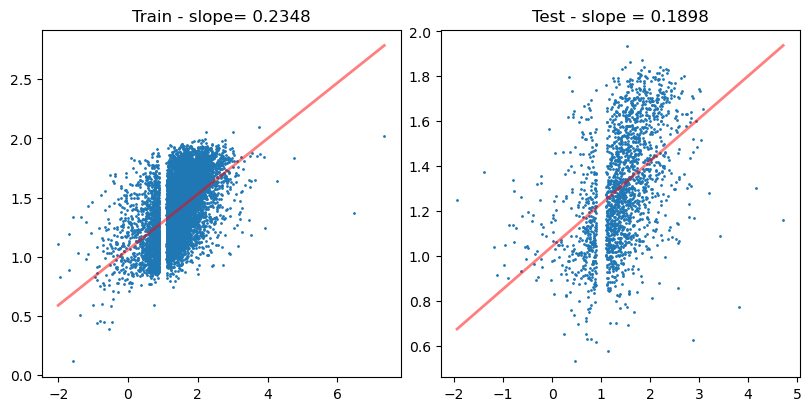

In [146]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4), constrained_layout=True)

axes[0].scatter(y_train, y_train_preds, s=1)

b, a = np.polyfit(y_train, y_train_preds, deg=1)
xseq = np.linspace(min(y_train), max(y_train))
axes[0].plot(xseq, a + b * xseq, color='r', lw=2, alpha=0.5)

axes[0].set_title(f"Train - slope= %.4f" % b)

axes[1].scatter(y_test, y_test_preds, s=1)

b, a = np.polyfit(y_test, y_test_preds, deg=1)
xseq = np.linspace(min(y_test), max(y_test))
axes[1].plot(xseq, a + b * xseq, color='r', lw=2, alpha=0.5)

axes[1].set_title(f"Test - slope = %.4f" % b)

plt.show()

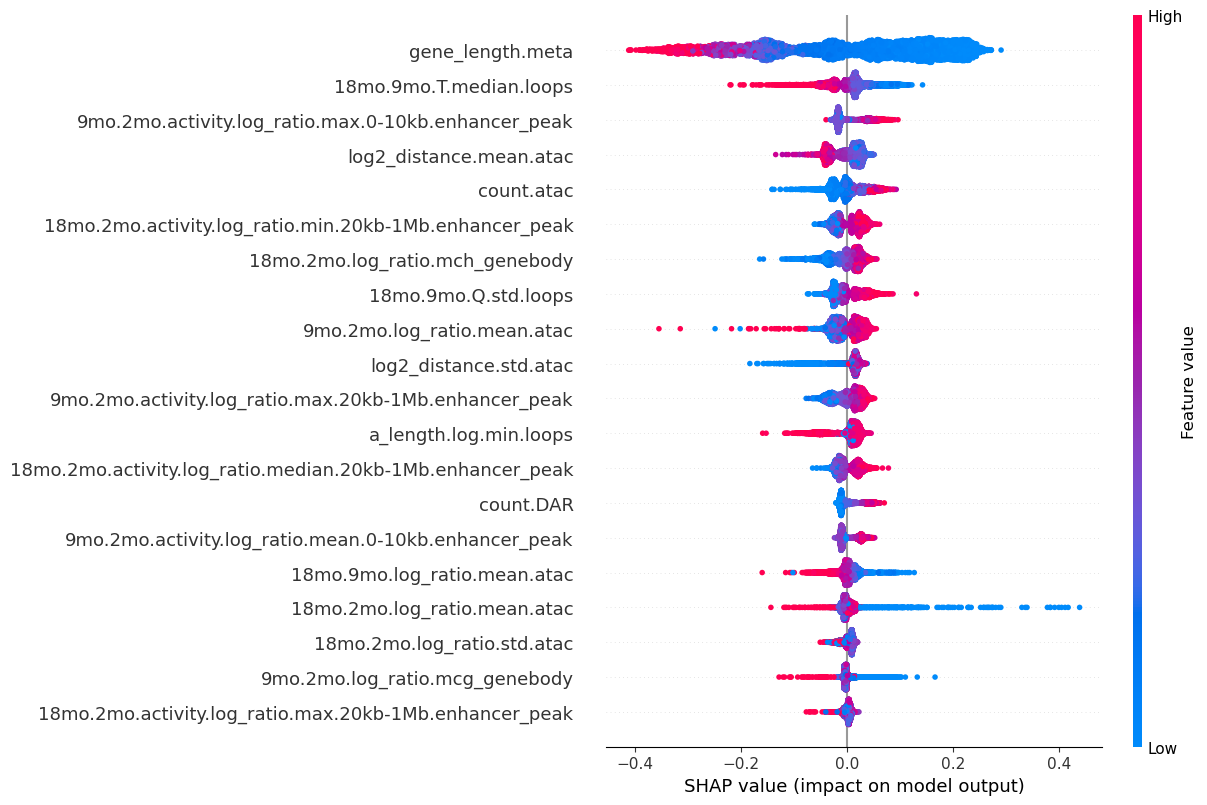

In [148]:
shap.plots.beeswarm(shap_values_2, max_display=20)

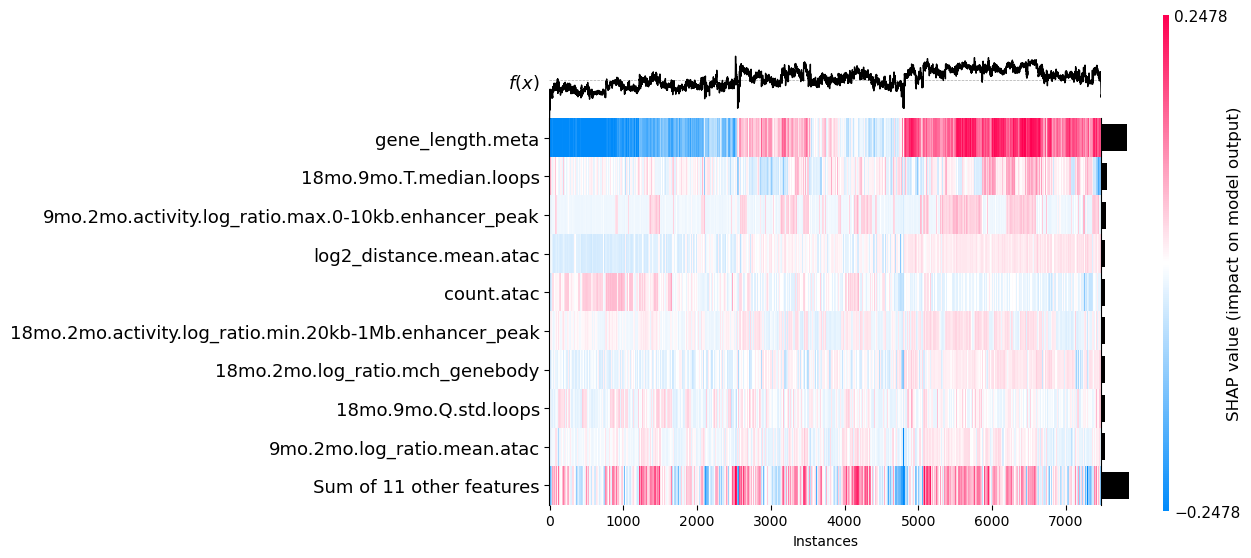

<Axes: xlabel='Instances'>

In [149]:
shap.plots.heatmap(shap_values_2)

In [154]:
inds = shap.utils.potential_interactions(shap_values_2[:, "log2_distance.mean.atac"], shap_values_2)

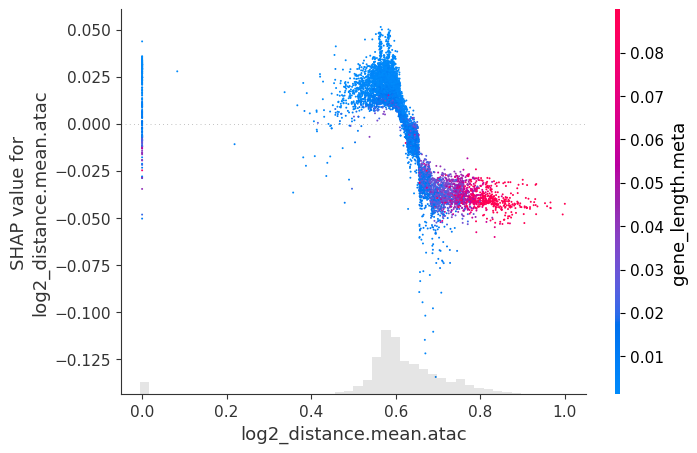

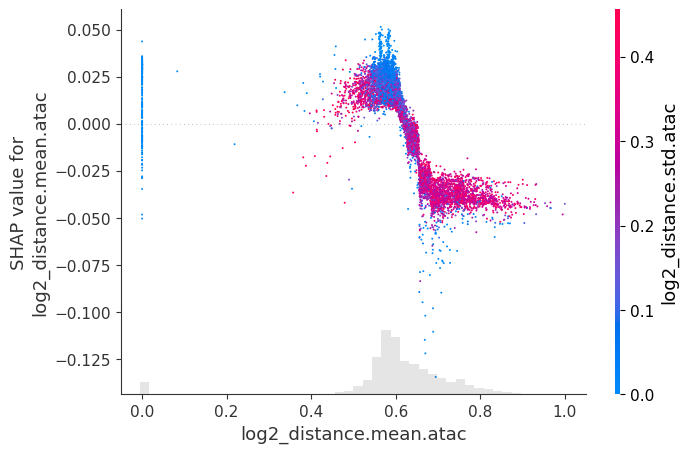

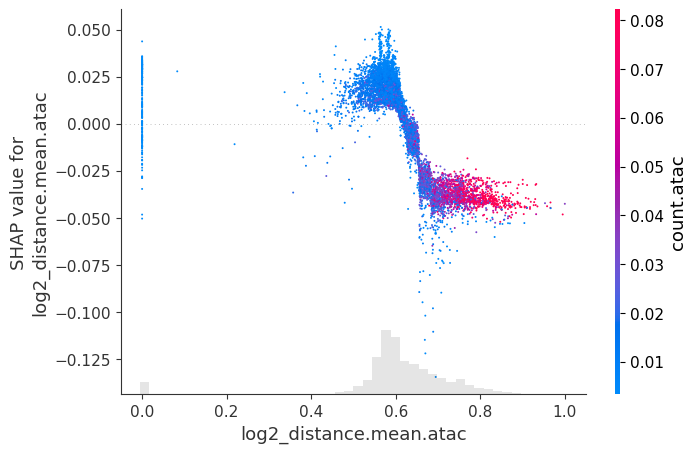

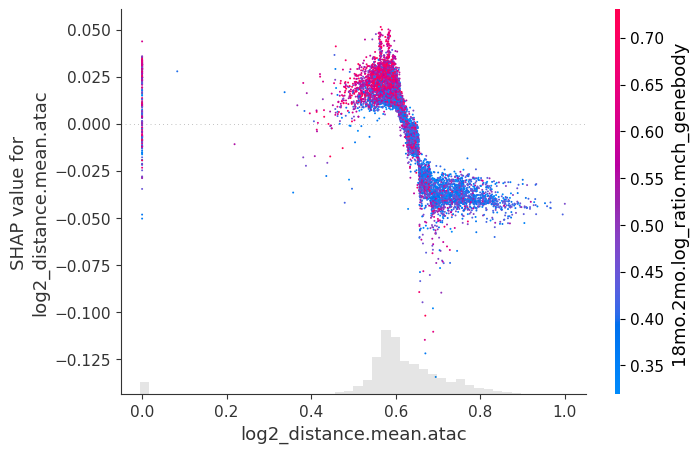

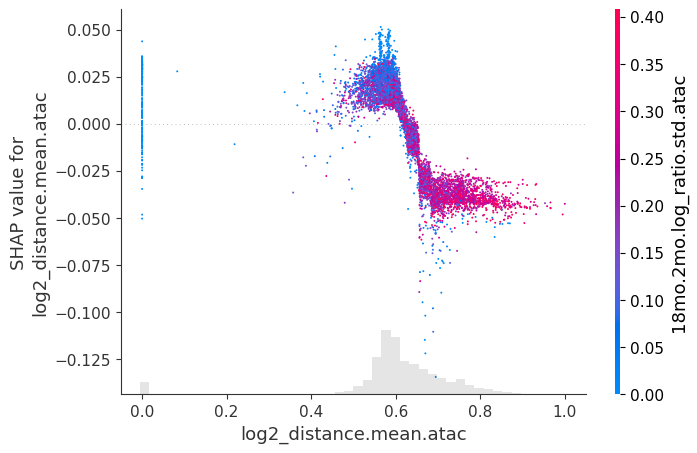

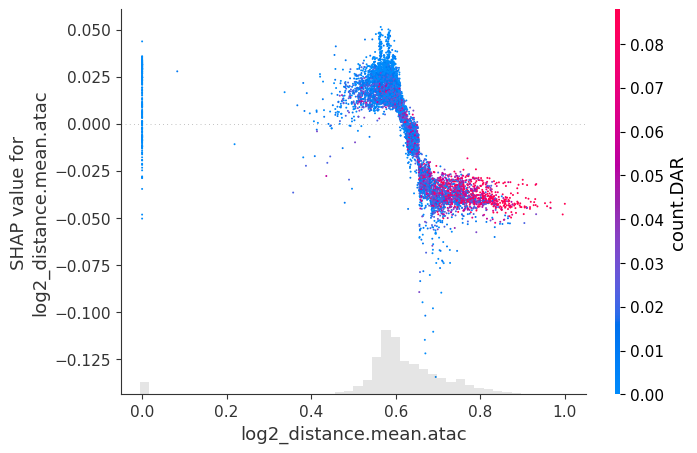

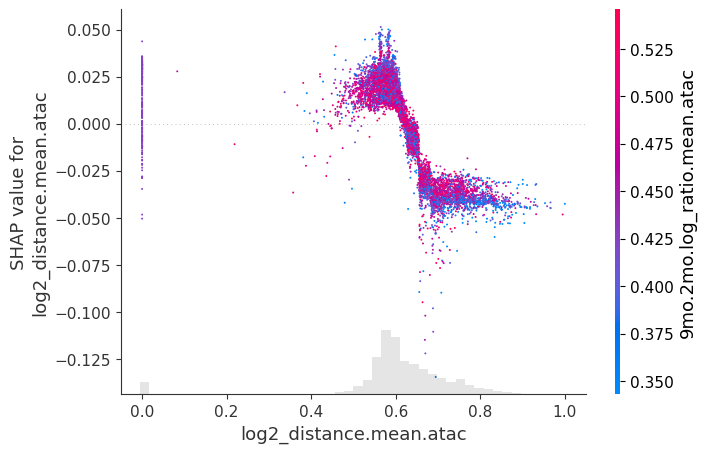

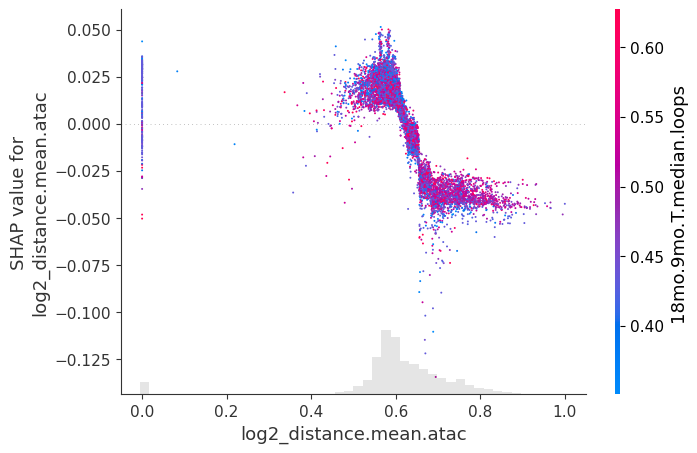

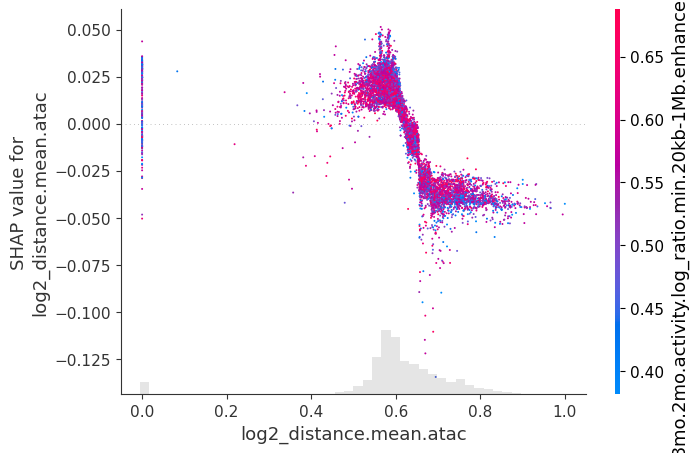

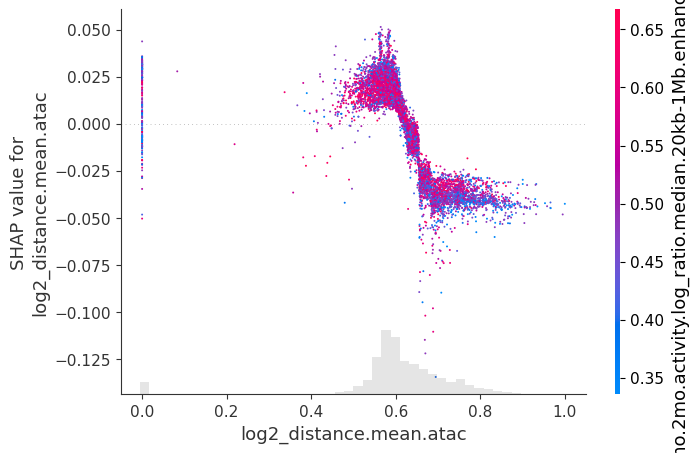

In [158]:
counter = 0
for i in inds:
    # _feat = shap_values.feature_names[i]
    # if _feat.split(".")[-1] == "loops":
    #     continue
    shap.plots.scatter(shap_values_2[:, "log2_distance.mean.atac"], color=shap_values_2[:, i], 
                       dot_size=2)
    counter+=1
    if counter == 10: 
        break

### All Features

In [27]:
explainer = shap.TreeExplainer(xgb_mod, X_train) # , feature_perturbation='interventional', model_output="predict_proba")
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 7469/7482 [05:15<00:00]        

In [137]:
df_temp = pd.DataFrame(shap_values.values, 
                               columns=X_train.columns, 
                               index=X_train.index)

df_rank = df_temp.abs().mean().sort_values(ascending=False)
df_rank = pd.DataFrame(df_rank).reset_index().reset_index().set_index('index')
df_rank.columns=[f'rank', f'abs_mean_shap']
df_rank[f'rank'] += 1

In [140]:
df_rank[:20].index

Index(['gene_length.meta',
       '18mo.2mo.activity.log_ratio.median.20kb-1Mb.enhancer_peak',
       'log2_distance.mean.atac', 'count.atac', 'a_length.log.min.loops',
       '18mo.2mo.log_ratio.mean.atac', '18mo.9mo.log_ratio.mean.atac',
       '9mo.2mo.log_ratio.mean.atac',
       '18mo.2mo.activity.log_ratio.max.20kb-1Mb.enhancer_peak',
       '9mo.2mo.activity.log_ratio.mean.0-10kb.enhancer_peak',
       '9mo.2mo.log_ratio.mcg_genebody', '18mo.2mo.log_ratio.std.atac',
       '18mo.9mo.T.median.loops',
       '9mo.2mo.activity.log_ratio.max.20kb-1Mb.enhancer_peak',
       '9mo.2mo.activity.log_ratio.max.0-10kb.enhancer_peak',
       '18mo.9mo.Q.std.loops',
       '18mo.2mo.activity.log_ratio.min.20kb-1Mb.enhancer_peak',
       'log2_distance.std.atac', '18mo.2mo.log_ratio.mch_genebody',
       'count.DAR'],
      dtype='object', name='index')

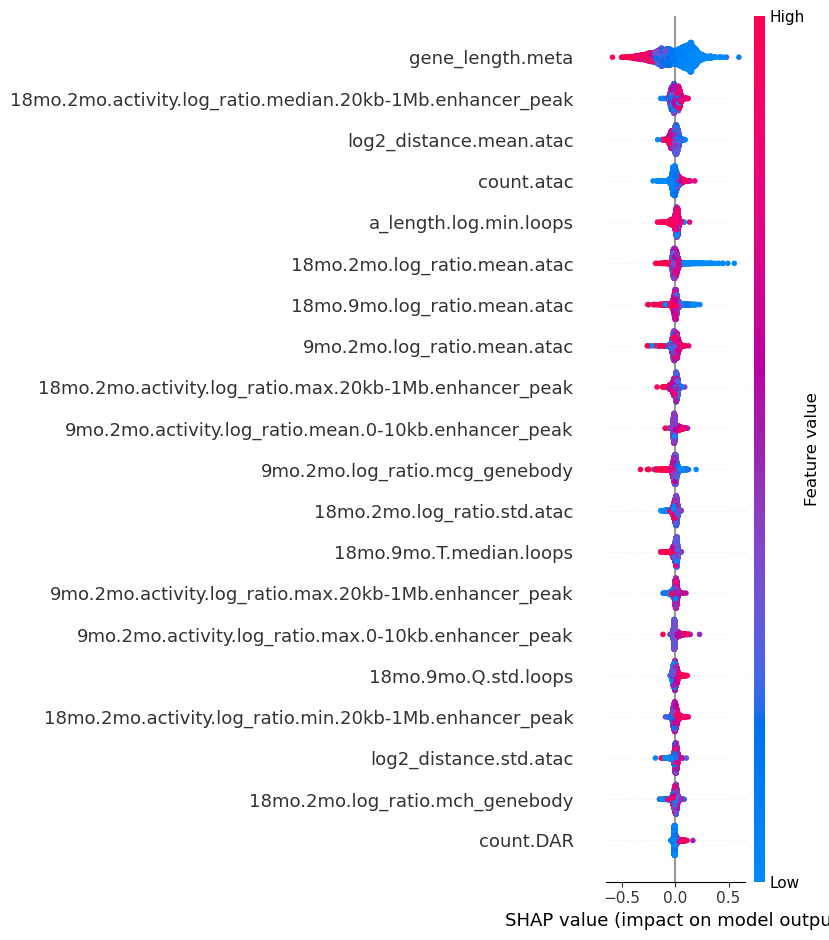

In [123]:
shap.summary_plot(shap_values, max_display=20)

In [ ]:
shap.plots.summary_(shap_values, max_display=20)

In [84]:
expected_value = explainer.expected_value

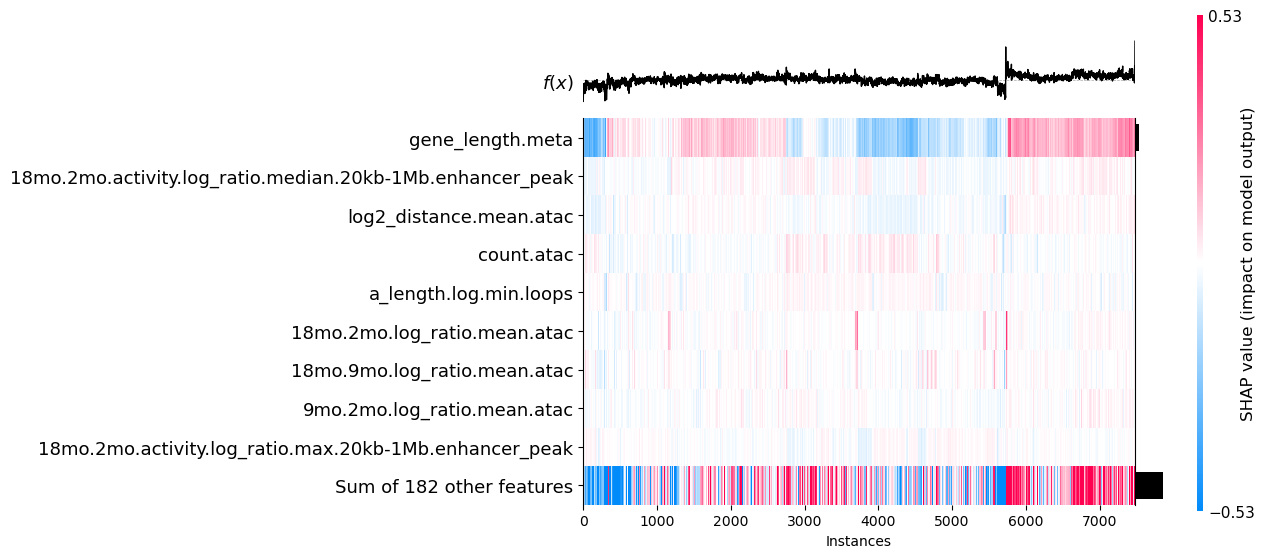

<Axes: xlabel='Instances'>

In [89]:
shap.plots.heatmap(shap_values)

In [95]:
shap_values.shape

(7482, 191)

In [102]:
inds = shap.utils.potential_interactions(shap_values[:, "18mo.2mo.log_ratio.mch_genebody"], shap_values)
inds

array([173, 185, 170, 169, 174, 159, 125, 123, 165, 161, 131, 153, 127,
       129, 186, 156, 167,   0, 155, 143,  79, 138, 121, 141, 189, 149,
       128, 147,  78, 124, 187, 190,  75,  84, 105, 135,  83, 171,  73,
        98,  77,  82, 112,  91, 184, 137, 175, 168, 188, 183, 111, 116,
        71, 176,  72, 122, 162, 182, 130, 178, 150,  96, 139,  89,  87,
        49,  64,  80,  59,  44, 108, 158,  76, 157, 144, 115, 109,  34,
        23, 110, 119, 154,  10,   7,  94, 118, 133,  17, 177,  90, 101,
         9,  12,  27,  97,  85,  92,  86,  39,  54,  22, 140,  93, 120,
       145,  81, 103,   2,   5, 134, 152,  24,  13,  14,   8,  11,  18,
        29,  21,  15, 151, 114,  16,  19, 106, 117, 146,  46,  32,  38,
        42,   3,   6,  30,  67,  70, 107,  20,  40,  31, 104, 180, 102,
       166, 113, 179,  47,   4,   1,  41,  95,  25,  26, 148,  48,  43,
        65,  68,  45,  35,  36,  28, 160, 164, 163,  53, 126, 142,  99,
        88,  51,  74,  50,  66,  69, 100,  52,  37,  33, 172, 13

In [113]:
shap_values.feature_names[inds[i]]

'a_length.log.min.loops'

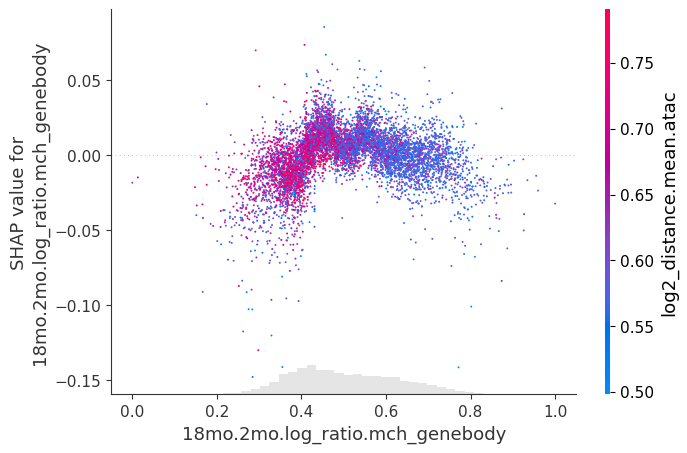

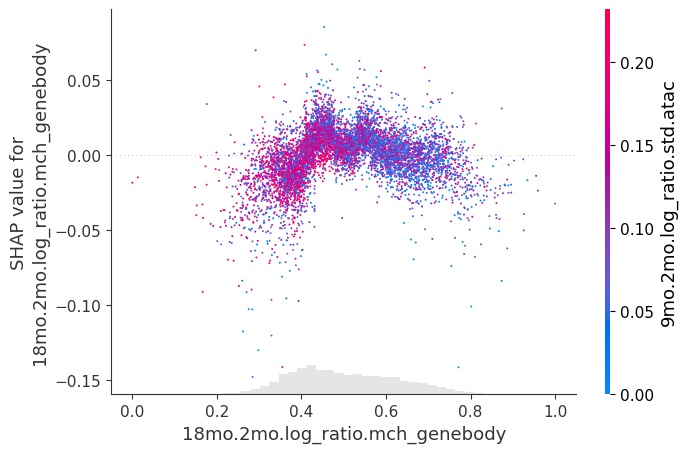

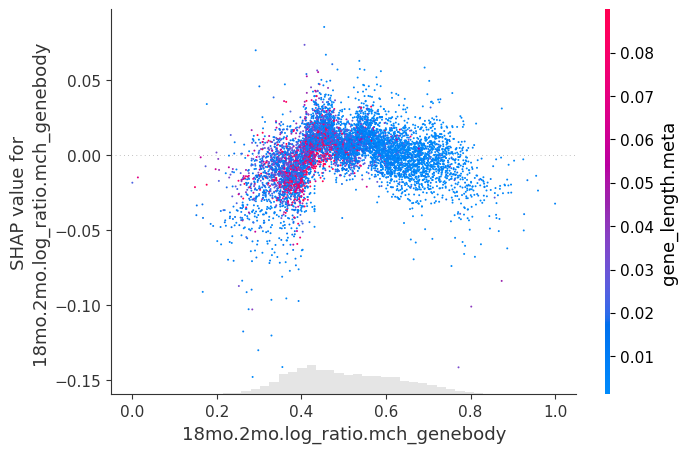

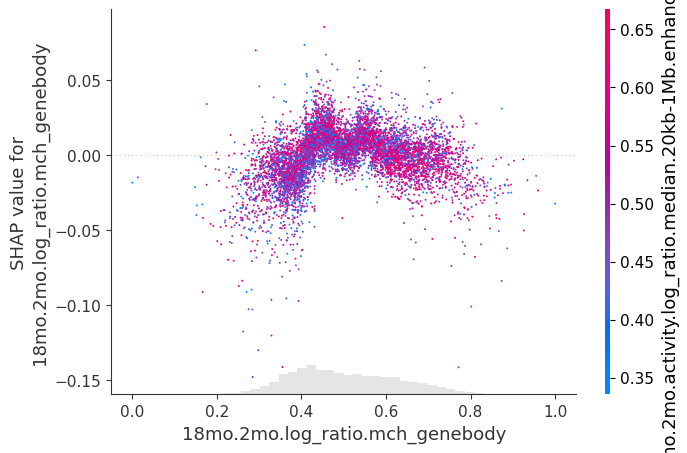

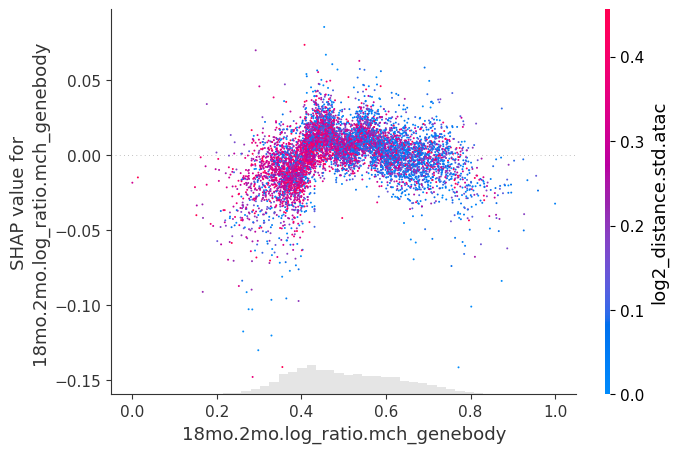

In [116]:
counter = 0
for i in inds:
    _feat = shap_values.feature_names[i]
    if _feat.split(".")[-1] == "loops":
        continue
    shap.plots.scatter(shap_values[:, "18mo.2mo.log_ratio.mch_genebody"], color=shap_values[:, i], 
                       dot_size=2)
    counter+=1
    if counter == 5: 
        break

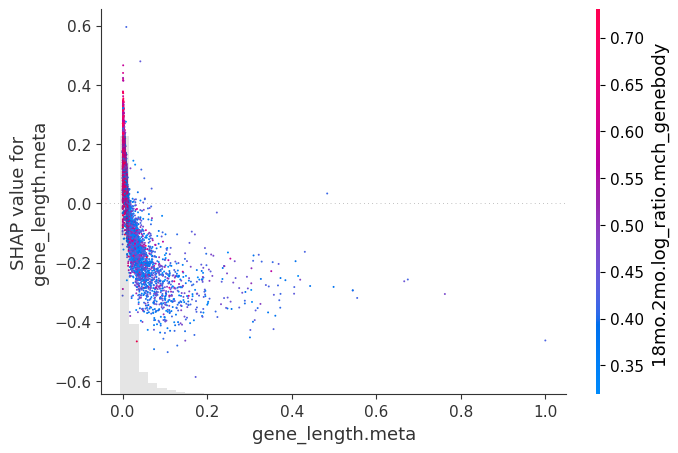

In [101]:
shap.plots.scatter(shap_values[:, "gene_length.meta"], color=shap_values[:, "18mo.2mo.log_ratio.mch_genebody"], 
                   dot_size=2)

In [80]:
pd.DataFrame(y_train).iloc[0]

avg_log2FC    1.29755
Name: Gm14391, dtype: float64

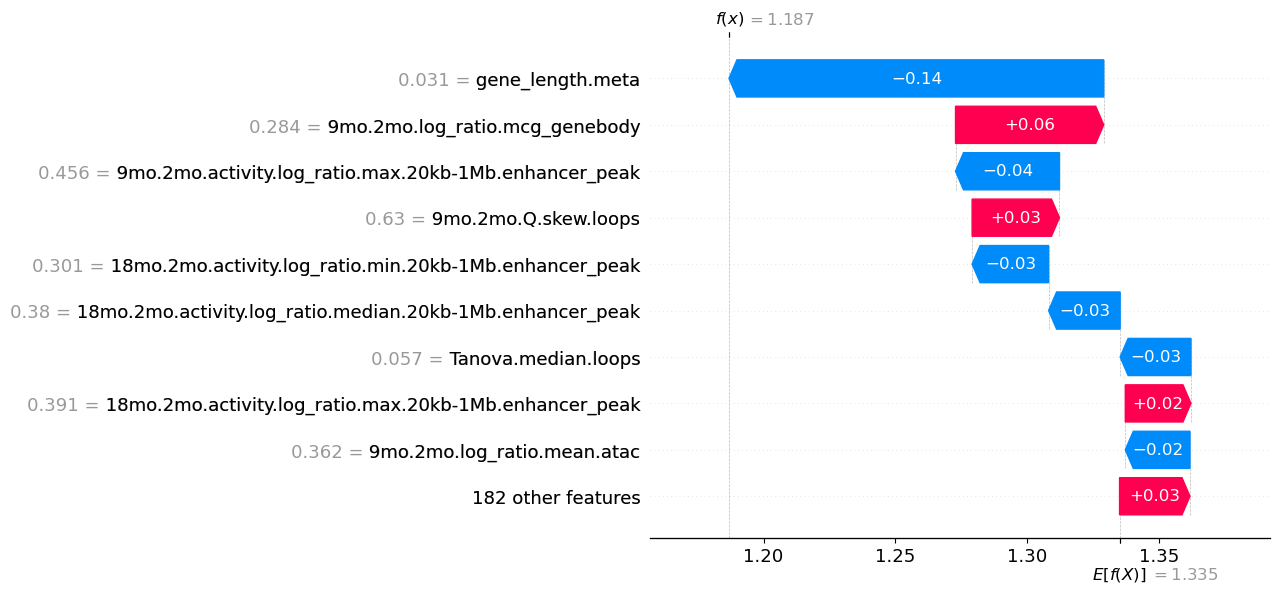

In [118]:
shap.plots.waterfall(shap_values[2])

In [32]:
y_test_preds = xgb_mod.predict(X_test)
y_train_preds = xgb_mod.predict(X_train)

In [39]:
y_test_preds = xgb_mod.predict(X_test)
y_train_preds = xgb_mod.predict(X_train)

tr_mae = mean_absolute_error(y_train, y_train_preds)
te_mae = mean_absolute_error(y_test, y_test_preds)

print("Train XGB MAE: %.2f%%" % (tr_mae*100))
print("Test XGB MAE: %.2f%%" %(te_mae*100))

Train XGB MAE: 4.90%
Test XGB MAE: 46.31%


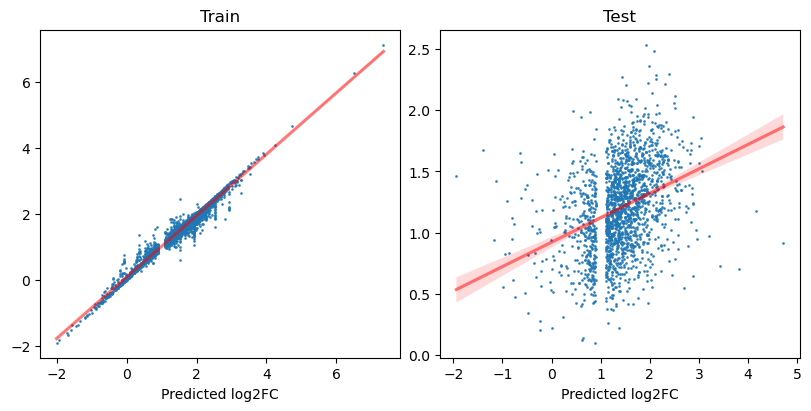

In [69]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4), constrained_layout=True)

sns.regplot(x=y_train, y=y_train_preds, ax=axes[0], 
            line_kws={'color':'red', 'alpha':0.5}, scatter_kws={'s':1})

axes[0].set_title("Train")
axes[0].set_xlabel("True log2FC")
axes[0].set_xlabel("Predicted log2FC")

sns.regplot(x=y_test, y=y_test_preds, ax=axes[1], 
            line_kws={'color':'red', 'alpha':0.5}, scatter_kws={'s':1})

axes[1].set_title("Test")
axes[1].set_xlabel("True log2FC")
axes[1].set_xlabel("Predicted log2FC")

plt.show()

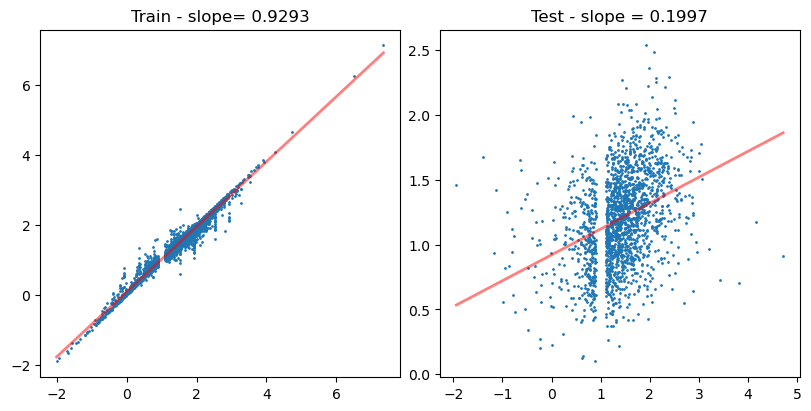

In [73]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4), constrained_layout=True)

axes[0].scatter(y_train, y_train_preds, s=1)

b, a = np.polyfit(y_train, y_train_preds, deg=1)
xseq = np.linspace(min(y_train), max(y_train))
axes[0].plot(xseq, a + b * xseq, color='r', lw=2, alpha=0.5)

axes[0].set_title(f"Train - slope= %.4f" % b)

axes[1].scatter(y_test, y_test_preds, s=1)

b, a = np.polyfit(y_test, y_test_preds, deg=1)
xseq = np.linspace(min(y_test), max(y_test))
axes[1].plot(xseq, a + b * xseq, color='r', lw=2, alpha=0.5)

axes[1].set_title(f"Test - slope = %.4f" % b)

plt.show()